# 인공지능 과제9 - Seq2Seq
## : Residual Connection을 적용한 챗봇 성능 향상
- 학번: 201711719
- 학과: 응용통계학과
- 이름: 심은선
- 제출날짜: 2020.11.15


In [2]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


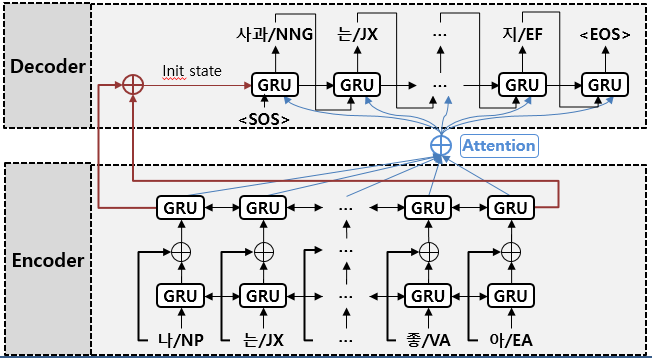

In [3]:
from IPython.display import Image
Image("/gdrive/My Drive/인공지능(4-2)/wk11.RNN/seq2seq_with_feature.PNG")

In [4]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
import torch.nn.functional as F


class Decoder(nn.Module):
    def __init__(self, config, embedding):
        super(Decoder, self).__init__()
        
        # 단어 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # GRU 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # 전체 어휘 개수
        self.vocab_size = config["vocab_size"]

        self.embedding = embedding # seq2seq에서 사용한 word embedding 그대로 사용
        self.dropout = nn.Dropout(config["dropout"])

        # GRU layer (한 방향)
        self.gru = nn.GRU(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=1)
        self.linear_1 = nn.Linear(in_features=self.hidden_size*2, out_features=self.hidden_size)
        self.linear_2 = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size) # vocab별 확률 분포 출력

    def forward(self, input, last_hidden, encoder_outputs): 
        # input: 현재 decoder step의 입력되는 형태소 index
        # last_hidden: step마다 hidden state
        # encoder_outputs: encoder 각 step에서 출력값

        # (batch_size, 1) -> (1, batch_size, embedding_size)
        embedded = self.embedding(input).unsqueeze(0)  # (1,B,N)
        embedded = self.dropout(embedded)

        # rnn_output : (1, batch_size, hidden_size) (출력)
        # hidden : (1, batch_size, hidden_size) (step마다 hidden state)
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # (1, batch_size, hidden_size) -> (batch_size, 1, hidden_size)
        # contiguous: 별도의 메모리에 복사 (attention 계산 & context vector와 연결해서 출력에도 값 활용)
        rnn_output_for_attention = rnn_output.transpose(0, 1).contiguous()
        # (curr_max_length, batch_size, hidden_size) -> (batch_size, hidden_size, curr_max_length)
        encoder_outputs = encoder_outputs.permute(1, 2, 0)

        # encoder output과 decoder 출력값을 내적해 attention weight 계산
        # (batch_size, 1, hidden_size) -> (batch_size, 1, curr_max_length)
        attn_weights = rnn_output_for_attention.bmm(encoder_outputs)

        # 0~1의 확률값으로 변경
        # (batch_size, curr_max_length) -> (batch_size, 1, curr_max_length)
        attn_weights = F.softmax(attn_weights, dim=-1)

        # attention weight와 encoder step의 출력값을 가중합해 context vector 생성
        # (batch_size, 1, curr_max_length) * (batch_size, curr_max_length, hidden_size) 
        # -> (batch_size, 1, hidden_size)
        context = attn_weights.bmm(encoder_outputs.transpose(1, 2))

        # Decoder의 출력값과 context vector를 연결해 최종 출력값을 구함
        # rnn_output : (1, batch_size, hidden_size) -> (batch_size, hidden_size)
        # context : (batch_size, 1, hidden_size) -> (batch_size, hidden_size)
        rnn_output, context = rnn_output.squeeze(0), context.squeeze(1)

        #  최종 출력값
        # (batch_size, hidden_size*2)
        concat_input = torch.cat(tensors=(rnn_output, context), dim=-1)

        # (batch_size, hidden_size*2) -> (batch_size, hidden_size)
        concat_output = torch.tanh(self.linear_1(concat_input))

        # (batch_size, hidden_size) -> (batch_size, vocab_size)
        output = self.linear_2(concat_output)

        # (step별 vocab 확률분포, GRU decoder의 hidden state)
        return output, hidden

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, config):
        super(Seq2Seq, self).__init__()

        # 전체 어휘 개수
        self.vocab_size = config["vocab_size"]
        
        # 단어 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # GRU 히든 사이즈: bi-direction 합해서 "hidden_size"
        self.hidden_size = config["hidden_size"]
        
        # 입력 sequence의 최대 길이
        self.max_length = config["max_length"]

        # 입력 데이터에 있는 각 단어 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        # 기존에 사전학습 된 단어 임베딩을 사용할 수도 있고 랜덤으로 초기화 한 후,
        # 모델 학습 과정 중에 같이 학습 시키는 것도 가능
        # 예제 코드는 랜덤으로 초기화 한 후 같이 학습하도록 설정
        self.word_embedding = nn.Embedding(num_embeddings=self.vocab_size,
                                           embedding_dim=self.embedding_size,
                                           padding_idx=0)

        # Bi-GRU layer
        self.bi_gru1 = nn.GRU(input_size=self.embedding_size,
                              # hidden_size=self.hidden_size // 2,
                             hidden_size=self.embedding_size // 2, # 한방향은 /2
                             num_layers=1,
                             bidirectional=True)
        self.bi_gru2 = nn.GRU(input_size=self.embedding_size,
                             hidden_size=self.hidden_size // 2, # 한방향은 /2
                             num_layers=1,
                             bidirectional=True)

        # Decoder layer: 이전 step의 출력 단어의 embedding을 다음 step에 입력해줘야하므로 embedding 사용
        self.decoder = Decoder(config, self.word_embedding)

        self.dropout = nn.Dropout(config["dropout"])


    # input_features: 입력 문장, output_features: 출력(정답) 문장
    def forward(self, input_features, output_features=None):
        batch_size = input_features.size()[0]

        # 입력 sequence의 실제 길이: padding index(0)을 제외한 길이
        input_feature_lengths = (input_features != 0).sum(dim=-1).cpu()

        # (batch_size, max_length) -> (batch_size, max_length, embedding_size)
        input_features = self.word_embedding(input_features)
        # (batch_size, max_length, embedding_size) -> (max_length, batch_size, embedding_size)
        input_features = input_features.transpose(0, 1) # bi-direction을 위해 차원 순서 변경
        packed_input_features = pack_padded_sequence(input_features, input_feature_lengths, batch_first=False, enforce_sorted=False)
        residual = packed_input_features

        # layer 1
        packed_gru_outputs, gru_hidden_states = self.bi_gru1(packed_input_features) # gru_hidden_states: bi-direction의 마지막 hidden state값, (hidden_size/2 + hidden_size/2)=hidden_size, packed_gru_output:(seq_len, batch, num_directions * hidden_size)
        # gru_outputs_unpacked, input_lengths_unpacked = pad_packed_sequence(packed_gru_outputs, batch_first=False) # gru_outputs_unpacked: 각 step에서 출력값

        # layer 2
        layer2_input = PackedSequence(residual[0]+packed_gru_outputs[0], residual[1])
        packed_gru_outputs2, gru_hidden_states = self.bi_gru2(layer2_input)
        gru_outputs_unpacked, input_lengths_unpacked = pad_packed_sequence(packed_gru_outputs2, batch_first=False) # gru_outputs_unpacked: 각 step에서 출력값
        

        # print("packed input features shape: ", packed_input_features.data.shape)
        # print("packed input features batch size: ", packed_input_features.batch_sizes)
        # print("packed input features batch size sum: ", packed_input_features.batch_sizes.sum())
        # print("packed input features batch_sizes length: ", len(packed_input_features.batch_sizes))
        
        # print()
        # print("pakced gru output shape: ", packed_gru_outputs.data.shape)
        # print("gru1 hidden states: ", gru_hidden_states.shape)
        # print("gru1 (packed) output shape: ", packed_gru_outputs[0].shape)
        # print("gru1 (packed) output batch size: ", packed_gru_outputs[1].sum())
        # print("gru1 (unpacked) output shape: ", gru_outputs_unpacked.shape)
        # print("\n\n")

        """
        packed input features shape:  torch.Size([380, 128]) # (packed_size, embedding_size)
        packed input features batch size:  tensor([32, 32, 32, 28, 26, 24, 24, 22, 20, 18, 17, 15, 14, 14, 11, 10,  9,  8,
                                                   5,  4,  4,  2,  2,  2,  2,  1,  1,  1]) 
        packed input features batch size sum:  tensor(380) # packed_input_features.batch_size.sum()=packed_size


        gru1 hidden states:  torch.Size([2, 32, 64])
        pakced gru output shape:  torch.Size([packed_size, 100])

        gru1 unpacked output shape:  torch.Size([unpacked_size, 32, 128])
        gru1 unpacked output shape:  torch.Size([28, 32, 100])
        """


        # 양방향 hidden_state 합치기
        # (2, batch_size, hidden_size/2) -> (batch_size, hidden_size)
        gru_hidden_states = torch.cat(tensors=(gru_hidden_states[0], gru_hidden_states[1]), dim=-1)

        # 각 step에서 출력값과 최종 hidden_state에 dropout 적용
        # gru_outputs_unpacked : (curr_max_length, batch_size, hidden_size)
        # gru_hidden_states : (batch_size, hidden_size)
        gru_outputs_unpacked, gru_hidden_states = self.dropout(gru_outputs_unpacked), self.dropout(gru_hidden_states)

        # (batch_size, ), 디코더의 시작 step 입력 값을 "--START--"로 초기화 (start symbol=1)
        decoder_input = torch.ones(size=(batch_size, ), dtype=torch.long).cuda()
        # decoder로 입력하기 위해 차원 추가
        # (batch_size, hidden_size) -> (1, batch_size, hidden_size)
        decoder_hidden = gru_hidden_states.unsqueeze(0)
        decoder_outputs = [] # decoder 각 step에서 생성한 출력값을 담는 리스트

        # Training
        if(output_features is not None):
            for step in range(self.max_length):
                # decoder_output : (batch_size, vocab_size) - 한 step에서 decoder 출력 단어 분포
                # decoder_hidden : (1, batch_size, hidden_size) - 한 step에서 decoder 상태값
                decoder_output, decoder_hidden = self.decoder(decoder_input, # start symbol로 초기화한 입력값
                                                              decoder_hidden, # bi-direction GRU 마지막 hidden state
                                                              gru_outputs_unpacked) # Encoder 각 step에서 출력값 -> Attention

                decoder_input = output_features[:, step] # training시 출력의 정답을 다음 step의 decoder의 input으로 사용
                decoder_outputs.append(decoder_output) # 예측한 출력값

            # decoder의 출력값이 각 step별 tensor 객체로 분리되어 있음 -> 하나의 tensor로
            # (max_length, batch_size, vocab_size)
            decoder_outputs = torch.stack(tensors=decoder_outputs, dim=0)
            # (max_length, batch_size, vocab_size) -> (batch_size, max_length, vocab_size)
            decoder_outputs = decoder_outputs.transpose(0, 1)

            loss_fct = nn.CrossEntropyLoss()

            # (batch_size, max_length, vocab_size) -> (batch_size*max_length, vocab_size)
            decoder_outputs = decoder_outputs.reshape(shape=(-1, self.vocab_size)) # cross entropy 계산을 위해 reshape
            # (batch_size, max_length) -> (batch_size*max_length)
            output_features = output_features.flatten()

            loss = loss_fct(decoder_outputs, output_features)

            return loss
        # Evalutation
        else:
            for t in range(self.max_length):
                # evaluation에서 decoder의 output이 다음 step의 input으로 들어감
                # decoder_output : (batch_size, vocab_size)
                # decoder_hidden : (1, batch_size, hidden_size)
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, gru_outputs_unpacked)

                # (batch_size, vocab_size) -> (batch_size, )
                decoder_input = decoder_output.argmax(dim=-1) # 확률이 가장 큰 단어를 선택해 다음 step의 input으로
                decoder_outputs.append(decoder_output.argmax(dim=-1)) # decoder 출력 단어

            # (max_length, batch_size, vocab_size)
            decoder_outputs = torch.stack(tensors=decoder_outputs, dim=0)
            # (max_length, batch_size, vocab_size) -> (batch_size, max_length, vocab_size)
            decoder_outputs = decoder_outputs.transpose(0, 1)

            return decoder_outputs

In [6]:
import torch
import numpy as np
from tqdm import tqdm


# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    datas = []
    for line in tqdm(lines, desc="read_data"):
        # 입력 문장을 \t으로 분리
        pieces = line.strip().split("\t")

        # 데이터의 형태가 올바른지 체크
        assert len(pieces) == 2

        # 입력 문자열을 형태소 단위로 분리
        question, answer = pieces[0].split(), pieces[1].split()

        datas.append((question, answer))

    return datas


# 데이터를 읽고 각각의 딕셔너리 생성
def read_vocab_data(vocab_data_path):
    word2idx, idx2word = {}, {}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        word = line.strip()
        word2idx[word] = len(word2idx)
        idx2word[word2idx[word]] = word

    return word2idx, idx2word


# 입력 데이터 전처리
def convert_data2feature(datas, max_length, word2idx):
    # 입력 데이터, 출력 데이터를 담을 리스트
    input_features, output_features = [], []

    for input_sequence, output_sequence in tqdm(datas, desc="convert_data2feature"):
        # 사전 설정한 max_length의 길이를 갖는 numpy array 생성
        input_feature, output_feature = np.zeros(shape=(max_length), dtype=np.int), np.zeros(shape=(max_length), dtype=np.int)

        # 입력 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        for index in range(len(input_sequence[:max_length])):
            input_feature[index] = word2idx[input_sequence[index]]

        # 출력 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        for index in range(len(output_sequence[:max_length])):
            output_feature[index] = word2idx[output_sequence[index]]
        # 출력 sequence의 마지막 부분에 "--END--" 추가
        output_feature[index+1] = word2idx["--END--"]

        # 변환한 데이터를 각 리스트에 저장
        input_features.append(input_feature)
        output_features.append(output_feature)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_features = torch.tensor(input_features, dtype=torch.long)
    output_features = torch.tensor(output_features, dtype=torch.long)

    return input_features, output_features

In [7]:
import os
import re
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import (DataLoader, TensorDataset)
import torch.optim as optim


def train(config):
    # 학습 데이터 읽기
    train_datas = read_data(config["train_data_path"])

    # 어휘 딕셔너리 생성
    word2idx, idx2word = read_vocab_data(config["vocab_data_path"])

    # 입력 데이터 전처리
    train_input_features, train_output_features \
        = convert_data2feature(train_datas, config["max_length"], word2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_features, train_output_features)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    # Seq2Seq 모델 객체 생성
    model = Seq2Seq(config).cuda()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(config["epoch"]):
        model.train()

        losses = []
        for step, batch in enumerate(tqdm(train_dataloader, desc="epoch_{}_train".format(epoch + 1))):
            batch = tuple(t.cuda() for t in batch)

            # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
            input_features, output_features = batch[0], batch[1]

            # 모델 학습
            loss = model(input_features, output_features)

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            losses.append(loss.data.item())

        torch.save(model.state_dict(), os.path.join(output_dir, "epoch_{}.pt".format(epoch + 1)))

        # epoch 별로 평균 loss 값 출력
        print("Average loss : {}\n".format(np.mean(losses)))

In [8]:
import os
from tqdm import tqdm
from torch.utils.data import (DataLoader, TensorDataset)

def test(config):
    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])

    # 어휘 딕셔너리 생성
    word2idx, idx2word = read_vocab_data(config["vocab_data_path"])

    test_input_features, test_output_features \
        = convert_data2feature(test_datas, config["max_length"], word2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_features, test_output_features)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=1)

    # Seq2Seq 모델 객체 생성
    model = Seq2Seq(config).cuda()
    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))

    model.eval()

    for step, batch in enumerate(tqdm(test_dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)

        # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
        input_features, output_features = batch[0], batch[1]

        # 모델 평가 (batch_size=1)
        predicts = model(input_features)
        predicts, input_features = predicts[0], input_features[0]

        # Tensor를 리스트로 변경
        predicts = predicts.cpu().numpy().tolist()
        input_features = input_features.cpu().numpy().tolist()

        if (step < 5):
          print()
          # 입력: end symbol 없음
          print("input_features : ", end=" ")
          for idx in input_features:
            word = idx2word[idx]

            if(word == "--PAD--"):
              break
            print(word, end=" ")
          print()

          # 출력: end symbol 있음
          print("predicts : ", end=" ")
          for idx in predicts:
            word = idx2word[idx]

            if(word == "--END--"):
              break
            print(word, end=" ")
          print()

In [11]:
if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/인공지능(4-2)/wk11.RNN"
    output_dir = os.path.join(root_dir, "output")

    if(not os.path.exists(output_dir)):
        os.makedirs(output_dir)

    config = {"mode": "train",
              "trained_model_name": "epoch_{}.pt".format(300),
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "vocab_data_path": os.path.join(root_dir, "vocab.txt"),
              "vocab_size": 19353,
              "embedding_size": 128,
              "hidden_size": 100,
              "max_length": 52,
              "epoch": 300,
              "batch_size": 32,
              "dropout": 0.3
              }

    if (config["mode"] == "train"):
        train(config)
    else:
        test(config)

epoch_2_train:   1%|          | 2/309 [00:00<00:29, 10.42it/s]

Average loss : 2.6980148634864287



epoch_3_train:   0%|          | 1/309 [00:00<00:32,  9.36it/s]

Average loss : 1.8678624830585466



epoch_4_train:   1%|          | 2/309 [00:00<00:29, 10.46it/s]

Average loss : 1.7461023072208788



epoch_5_train:   1%|          | 2/309 [00:00<00:30, 10.20it/s]

Average loss : 1.6524474296755003



epoch_6_train:   1%|          | 2/309 [00:00<00:29, 10.58it/s]

Average loss : 1.5847898602099866



epoch_7_train:   0%|          | 1/309 [00:00<00:31,  9.72it/s]

Average loss : 1.5298900264752335



epoch_8_train:   1%|          | 2/309 [00:00<00:30, 10.13it/s]

Average loss : 1.4826704499019387



epoch_9_train:   0%|          | 1/309 [00:00<00:33,  9.22it/s]

Average loss : 1.445886447591689



epoch_10_train:   1%|          | 2/309 [00:00<00:29, 10.38it/s]

Average loss : 1.4091000066991763



epoch_11_train:   1%|          | 2/309 [00:00<00:28, 10.94it/s]

Average loss : 1.3794467132839956



epoch_12_train:   1%|          | 2/309 [00:00<00:29, 10.54it/s]

Average loss : 1.3549779672838724



epoch_13_train:   0%|          | 1/309 [00:00<00:32,  9.42it/s]

Average loss : 1.329276975690354



epoch_14_train:   1%|          | 2/309 [00:00<00:28, 10.64it/s]

Average loss : 1.3053920253580829



epoch_15_train:   1%|          | 2/309 [00:00<00:27, 11.00it/s]

Average loss : 1.2835345736985069



epoch_16_train:   1%|          | 2/309 [00:00<00:30, 10.18it/s]

Average loss : 1.2630512506059073



epoch_17_train:   1%|          | 2/309 [00:00<00:28, 10.79it/s]

Average loss : 1.2415178825168547



epoch_18_train:   0%|          | 1/309 [00:00<00:33,  9.22it/s]

Average loss : 1.2281193056152861



epoch_19_train:   1%|          | 2/309 [00:00<00:29, 10.56it/s]

Average loss : 1.2085945972732741



epoch_20_train:   1%|          | 2/309 [00:00<00:29, 10.54it/s]

Average loss : 1.1931062564494925



epoch_21_train:   1%|          | 2/309 [00:00<00:29, 10.39it/s]

Average loss : 1.1751553258077998



epoch_22_train:   0%|          | 1/309 [00:00<00:31,  9.73it/s]

Average loss : 1.161497557433292



epoch_23_train:   1%|          | 2/309 [00:00<00:29, 10.48it/s]

Average loss : 1.145568643187242



epoch_24_train:   1%|          | 2/309 [00:00<00:29, 10.56it/s]

Average loss : 1.1317400806930074



epoch_25_train:   1%|          | 2/309 [00:00<00:28, 10.79it/s]

Average loss : 1.119062342304242



epoch_26_train:   1%|          | 2/309 [00:00<00:28, 10.78it/s]

Average loss : 1.1054456532965973



epoch_27_train:   1%|          | 2/309 [00:00<00:28, 10.82it/s]

Average loss : 1.0921415956660767



epoch_28_train:   1%|          | 2/309 [00:00<00:28, 10.67it/s]

Average loss : 1.0807338904794366



epoch_29_train:   0%|          | 1/309 [00:00<00:31,  9.93it/s]

Average loss : 1.069152223832399



epoch_30_train:   0%|          | 1/309 [00:00<00:31,  9.82it/s]

Average loss : 1.059485460755123



epoch_31_train:   1%|          | 2/309 [00:00<00:28, 10.67it/s]

Average loss : 1.0481244416298603



epoch_32_train:   0%|          | 1/309 [00:00<00:31,  9.82it/s]

Average loss : 1.0354124228545376



epoch_33_train:   1%|          | 2/309 [00:00<00:28, 10.72it/s]

Average loss : 1.0282057286466209



epoch_34_train:   0%|          | 1/309 [00:00<00:31,  9.92it/s]

Average loss : 1.0160947351393963



epoch_35_train:   1%|          | 2/309 [00:00<00:28, 10.63it/s]

Average loss : 1.0065924916838365



epoch_36_train:   1%|          | 2/309 [00:00<00:29, 10.44it/s]

Average loss : 0.9942249536128491



epoch_37_train:   1%|          | 2/309 [00:00<00:29, 10.47it/s]

Average loss : 0.9856491034856506



epoch_38_train:   1%|          | 2/309 [00:00<00:28, 10.76it/s]

Average loss : 0.9782825714176141



epoch_39_train:   1%|          | 2/309 [00:00<00:30, 10.19it/s]

Average loss : 0.9700198194741431



epoch_40_train:   1%|          | 2/309 [00:00<00:28, 10.67it/s]

Average loss : 0.9610401004263498



epoch_41_train:   0%|          | 1/309 [00:00<00:33,  9.24it/s]

Average loss : 0.9529081264745842



epoch_42_train:   0%|          | 1/309 [00:00<00:33,  9.28it/s]

Average loss : 0.9446648872400178



epoch_43_train:   1%|          | 2/309 [00:00<00:29, 10.55it/s]

Average loss : 0.936396093623152



epoch_44_train:   1%|          | 2/309 [00:00<00:28, 10.59it/s]

Average loss : 0.9280699398911115



epoch_45_train:   0%|          | 1/309 [00:00<00:31,  9.92it/s]

Average loss : 0.9209176986734459



epoch_46_train:   1%|          | 2/309 [00:00<00:29, 10.54it/s]

Average loss : 0.916533050799447



epoch_47_train:   1%|          | 2/309 [00:00<00:28, 10.66it/s]

Average loss : 0.9079325689081236



epoch_48_train:   1%|          | 2/309 [00:00<00:29, 10.37it/s]

Average loss : 0.9005530958808355



epoch_49_train:   0%|          | 1/309 [00:00<00:31,  9.71it/s]

Average loss : 0.8926954506670387



epoch_50_train:   1%|          | 2/309 [00:00<00:29, 10.56it/s]

Average loss : 0.8863984566290402



epoch_51_train:   1%|          | 2/309 [00:00<00:29, 10.50it/s]

Average loss : 0.8808295925458273



epoch_52_train:   1%|          | 2/309 [00:00<00:29, 10.53it/s]

Average loss : 0.8745775637503195



epoch_53_train:   0%|          | 1/309 [00:00<00:31,  9.63it/s]

Average loss : 0.8683035350540309



epoch_54_train:   0%|          | 1/309 [00:00<00:32,  9.61it/s]

Average loss : 0.8617518731305515



epoch_55_train:   1%|          | 2/309 [00:00<00:29, 10.56it/s]

Average loss : 0.8543091684483402



epoch_56_train:   1%|          | 2/309 [00:00<00:28, 10.72it/s]

Average loss : 0.8481718591116008



epoch_57_train:   1%|          | 2/309 [00:00<00:29, 10.44it/s]

Average loss : 0.844260408075882



epoch_58_train:   0%|          | 1/309 [00:00<00:32,  9.62it/s]

Average loss : 0.8399807731696317



epoch_59_train:   0%|          | 1/309 [00:00<00:32,  9.41it/s]

Average loss : 0.8338107771472252



epoch_60_train:   1%|          | 2/309 [00:00<00:28, 10.89it/s]

Average loss : 0.8287293966919859



epoch_61_train:   0%|          | 1/309 [00:00<00:33,  9.27it/s]

Average loss : 0.8224837834009461



epoch_62_train:   1%|          | 2/309 [00:00<00:29, 10.26it/s]

Average loss : 0.8169515032598502



epoch_63_train:   1%|          | 2/309 [00:00<00:30, 10.19it/s]

Average loss : 0.8127488117773556



epoch_64_train:   1%|          | 2/309 [00:00<00:29, 10.43it/s]

Average loss : 0.8095141874933706



epoch_65_train:   0%|          | 1/309 [00:00<00:32,  9.59it/s]

Average loss : 0.8031150654295888



epoch_66_train:   1%|          | 2/309 [00:00<00:29, 10.43it/s]

Average loss : 0.7976310161518048



epoch_67_train:   1%|          | 2/309 [00:00<00:28, 10.86it/s]

Average loss : 0.7931446226669361



epoch_68_train:   0%|          | 1/309 [00:00<00:30,  9.96it/s]

Average loss : 0.7886109056982021



epoch_69_train:   1%|          | 2/309 [00:00<00:29, 10.41it/s]

Average loss : 0.7838997372145792



epoch_70_train:   0%|          | 1/309 [00:00<00:31,  9.93it/s]

Average loss : 0.7820817818533641



epoch_71_train:   0%|          | 1/309 [00:00<00:32,  9.53it/s]

Average loss : 0.777465247992173



epoch_72_train:   0%|          | 0/309 [00:00<?, ?it/s]

Average loss : 0.7710681776591489



epoch_73_train:   0%|          | 1/309 [00:00<00:32,  9.45it/s]

Average loss : 0.7686556581540401



epoch_74_train:   0%|          | 0/309 [00:00<?, ?it/s]

Average loss : 0.7634706229067929



epoch_75_train:   0%|          | 1/309 [00:00<00:31,  9.88it/s]

Average loss : 0.7610665119967415



epoch_76_train:   0%|          | 1/309 [00:00<00:31,  9.83it/s]

Average loss : 0.7563875186404749



epoch_77_train:   0%|          | 1/309 [00:00<00:32,  9.61it/s]

Average loss : 0.7536998393080381



epoch_78_train:   1%|          | 2/309 [00:00<00:28, 10.69it/s]

Average loss : 0.7479223410288492



epoch_79_train:   1%|          | 2/309 [00:00<00:29, 10.36it/s]

Average loss : 0.7442979710387566



epoch_80_train:   1%|          | 2/309 [00:00<00:29, 10.54it/s]

Average loss : 0.7407937807944215



epoch_81_train:   1%|          | 2/309 [00:00<00:30, 10.19it/s]

Average loss : 0.7372754073451638



epoch_82_train:   1%|          | 2/309 [00:00<00:29, 10.57it/s]

Average loss : 0.7349488953170653



epoch_83_train:   1%|          | 2/309 [00:00<00:29, 10.36it/s]

Average loss : 0.7322569823187918



epoch_84_train:   1%|          | 2/309 [00:00<00:29, 10.37it/s]

Average loss : 0.727457845866873



epoch_85_train:   1%|          | 2/309 [00:00<00:28, 10.67it/s]

Average loss : 0.725331054825613



epoch_86_train:   1%|          | 2/309 [00:00<00:29, 10.57it/s]

Average loss : 0.7220585992421147



epoch_87_train:   1%|          | 2/309 [00:00<00:29, 10.53it/s]

Average loss : 0.71840336340145



epoch_88_train:   1%|          | 2/309 [00:00<00:29, 10.57it/s]

Average loss : 0.7155745882046647



epoch_89_train:   1%|          | 2/309 [00:00<00:29, 10.40it/s]

Average loss : 0.7104168276763657



epoch_90_train:   0%|          | 1/309 [00:00<00:30,  9.98it/s]

Average loss : 0.7088956208869477



epoch_91_train:   1%|          | 2/309 [00:00<00:29, 10.47it/s]

Average loss : 0.7055172426415107



epoch_92_train:   1%|          | 2/309 [00:00<00:29, 10.57it/s]

Average loss : 0.7026345174289444



epoch_93_train:   1%|          | 2/309 [00:00<00:28, 10.76it/s]

Average loss : 0.699252346186962



epoch_94_train:   1%|          | 2/309 [00:00<00:28, 10.72it/s]

Average loss : 0.6971235623444554



epoch_95_train:   0%|          | 1/309 [00:00<00:32,  9.37it/s]

Average loss : 0.6938241058568738



epoch_96_train:   0%|          | 1/309 [00:00<00:31,  9.70it/s]

Average loss : 0.6912267948817281



epoch_97_train:   1%|          | 2/309 [00:00<00:29, 10.49it/s]

Average loss : 0.6890660454925982



epoch_98_train:   0%|          | 0/309 [00:00<?, ?it/s]

Average loss : 0.6858161225866731



epoch_99_train:   1%|          | 2/309 [00:00<00:28, 10.64it/s]

Average loss : 0.6835565598844324



epoch_100_train:   1%|          | 2/309 [00:00<00:28, 10.70it/s]

Average loss : 0.6792205759236728



epoch_101_train:   1%|          | 2/309 [00:00<00:29, 10.39it/s]

Average loss : 0.6772919859508094



epoch_102_train:   1%|          | 2/309 [00:00<00:29, 10.53it/s]

Average loss : 0.6752972260455098



epoch_103_train:   1%|          | 2/309 [00:00<00:28, 10.73it/s]

Average loss : 0.6719631461070965



epoch_104_train:   1%|          | 2/309 [00:00<00:28, 10.71it/s]

Average loss : 0.6697676965912569



epoch_105_train:   1%|          | 2/309 [00:00<00:28, 10.88it/s]

Average loss : 0.6682491919755164



epoch_106_train:   0%|          | 1/309 [00:00<00:31,  9.70it/s]

Average loss : 0.6649463442922796



epoch_107_train:   0%|          | 1/309 [00:00<00:31,  9.68it/s]

Average loss : 0.6636208142470388



epoch_108_train:   0%|          | 1/309 [00:00<00:31,  9.69it/s]

Average loss : 0.660375789338331



epoch_109_train:   0%|          | 1/309 [00:00<00:32,  9.62it/s]

Average loss : 0.6572165174777453



epoch_110_train:   1%|          | 2/309 [00:00<00:29, 10.54it/s]

Average loss : 0.6561711441158863



epoch_111_train:   0%|          | 1/309 [00:00<00:33,  9.26it/s]

Average loss : 0.6525995874096274



epoch_112_train:   1%|          | 2/309 [00:00<00:29, 10.35it/s]

Average loss : 0.652358938768072



epoch_113_train:   1%|          | 2/309 [00:00<00:29, 10.49it/s]

Average loss : 0.649870191577183



epoch_114_train:   1%|          | 2/309 [00:00<00:29, 10.55it/s]

Average loss : 0.6469007526979478



epoch_115_train:   0%|          | 1/309 [00:00<00:31,  9.71it/s]

Average loss : 0.64551731336464



epoch_116_train:   0%|          | 1/309 [00:00<00:31,  9.65it/s]

Average loss : 0.6437547706477464



epoch_117_train:   1%|          | 2/309 [00:00<00:29, 10.59it/s]

Average loss : 0.6404490006008581



epoch_118_train:   0%|          | 1/309 [00:00<00:31,  9.77it/s]

Average loss : 0.6383891970787233



epoch_119_train:   0%|          | 1/309 [00:00<00:31,  9.74it/s]

Average loss : 0.6377844702464477



epoch_120_train:   1%|          | 2/309 [00:00<00:29, 10.55it/s]

Average loss : 0.6346585102451657



epoch_121_train:   1%|          | 2/309 [00:00<00:28, 10.72it/s]

Average loss : 0.6315520351758667



epoch_122_train:   1%|          | 2/309 [00:00<00:27, 11.02it/s]

Average loss : 0.6306698836362092



epoch_123_train:   1%|          | 2/309 [00:00<00:28, 10.90it/s]

Average loss : 0.6294177569039046



epoch_124_train:   0%|          | 1/309 [00:00<00:31,  9.63it/s]

Average loss : 0.6275585223363055



epoch_125_train:   0%|          | 1/309 [00:00<00:32,  9.57it/s]

Average loss : 0.6226168847778468



epoch_126_train:   1%|          | 2/309 [00:00<00:28, 10.73it/s]

Average loss : 0.6244019594971801



epoch_127_train:   1%|          | 2/309 [00:00<00:28, 10.67it/s]

Average loss : 0.6197997185018842



epoch_128_train:   1%|          | 2/309 [00:00<00:29, 10.39it/s]

Average loss : 0.6182483757776736



epoch_129_train:   1%|          | 2/309 [00:00<00:28, 10.72it/s]

Average loss : 0.6174064595915353



epoch_130_train:   1%|          | 2/309 [00:00<00:28, 10.78it/s]

Average loss : 0.6154075986359112



epoch_131_train:   1%|          | 2/309 [00:00<00:28, 10.76it/s]

Average loss : 0.613899344668805



epoch_132_train:   1%|          | 2/309 [00:00<00:30, 10.18it/s]

Average loss : 0.6123223757087991



epoch_133_train:   0%|          | 1/309 [00:00<00:37,  8.15it/s]

Average loss : 0.6116517690586041



epoch_134_train:   0%|          | 1/309 [00:00<00:31,  9.79it/s]

Average loss : 0.6094287841258311



epoch_135_train:   0%|          | 1/309 [00:00<00:33,  9.28it/s]

Average loss : 0.607357483369247



epoch_136_train:   1%|          | 2/309 [00:00<00:30, 10.08it/s]

Average loss : 0.604851744514453



epoch_137_train:   1%|          | 2/309 [00:00<00:29, 10.48it/s]

Average loss : 0.6049256031567225



epoch_138_train:   1%|          | 2/309 [00:00<00:29, 10.54it/s]

Average loss : 0.6019132178771072



epoch_139_train:   0%|          | 1/309 [00:00<00:32,  9.62it/s]

Average loss : 0.6014687710209572



epoch_140_train:   1%|          | 2/309 [00:00<00:29, 10.31it/s]

Average loss : 0.5980433170656556



epoch_141_train:   0%|          | 1/309 [00:00<00:36,  8.40it/s]

Average loss : 0.5963427407070271



epoch_142_train:   1%|          | 2/309 [00:00<00:29, 10.31it/s]

Average loss : 0.5955946112720711



epoch_143_train:   1%|          | 2/309 [00:00<00:28, 10.62it/s]

Average loss : 0.5919575556196441



epoch_144_train:   1%|          | 2/309 [00:00<00:29, 10.41it/s]

Average loss : 0.5916990362903447



epoch_145_train:   1%|          | 2/309 [00:00<00:27, 11.03it/s]

Average loss : 0.5903413044981972



epoch_146_train:   0%|          | 1/309 [00:00<00:33,  9.33it/s]

Average loss : 0.5892169174638767



epoch_147_train:   1%|          | 2/309 [00:00<00:29, 10.30it/s]

Average loss : 0.5869000224233831



epoch_148_train:   1%|          | 2/309 [00:00<00:29, 10.32it/s]

Average loss : 0.5872554626665455



epoch_149_train:   1%|          | 2/309 [00:00<00:29, 10.45it/s]

Average loss : 0.5842614842271342



epoch_150_train:   1%|          | 2/309 [00:00<00:29, 10.26it/s]

Average loss : 0.5825320810176022



epoch_151_train:   0%|          | 1/309 [00:00<00:32,  9.39it/s]

Average loss : 0.5820736337248176



epoch_152_train:   1%|          | 2/309 [00:00<00:29, 10.28it/s]

Average loss : 0.5790301331810195



epoch_153_train:   1%|          | 2/309 [00:00<00:28, 10.80it/s]

Average loss : 0.57901110029915



epoch_154_train:   0%|          | 1/309 [00:00<00:31,  9.68it/s]

Average loss : 0.5769201195934444



epoch_155_train:   1%|          | 2/309 [00:00<00:28, 10.91it/s]

Average loss : 0.5765824234987154



epoch_156_train:   1%|          | 2/309 [00:00<00:28, 10.72it/s]

Average loss : 0.574290280589008



epoch_157_train:   1%|          | 2/309 [00:00<00:28, 10.66it/s]

Average loss : 0.573397903477104



epoch_158_train:   1%|          | 2/309 [00:00<00:28, 10.90it/s]

Average loss : 0.5733224041639409



epoch_159_train:   1%|          | 2/309 [00:00<00:28, 10.89it/s]

Average loss : 0.5703081120179309



epoch_160_train:   1%|          | 2/309 [00:00<00:28, 10.68it/s]

Average loss : 0.5689807999095484



epoch_161_train:   1%|          | 2/309 [00:00<00:28, 10.72it/s]

Average loss : 0.5668775794189724



epoch_162_train:   1%|          | 2/309 [00:00<00:28, 10.91it/s]

Average loss : 0.5676607655475826



epoch_163_train:   0%|          | 1/309 [00:00<00:30,  9.94it/s]

Average loss : 0.5660498819304901



epoch_164_train:   0%|          | 1/309 [00:00<00:31,  9.78it/s]

Average loss : 0.5651931072130172



epoch_165_train:   1%|          | 2/309 [00:00<00:28, 10.80it/s]

Average loss : 0.564569160197545



epoch_166_train:   1%|          | 2/309 [00:00<00:28, 10.96it/s]

Average loss : 0.5628918376555335



epoch_167_train:   1%|          | 2/309 [00:00<00:28, 10.70it/s]

Average loss : 0.5610496622651912



epoch_168_train:   1%|          | 2/309 [00:00<00:27, 11.01it/s]

Average loss : 0.5572270834908902



epoch_169_train:   1%|          | 2/309 [00:00<00:27, 11.16it/s]

Average loss : 0.5566603723660256



epoch_170_train:   1%|          | 2/309 [00:00<00:28, 10.84it/s]

Average loss : 0.5574101435327993



epoch_171_train:   1%|          | 2/309 [00:00<00:28, 10.96it/s]

Average loss : 0.5566101357774828



epoch_172_train:   1%|          | 2/309 [00:00<00:29, 10.39it/s]

Average loss : 0.5556046615526514



epoch_173_train:   1%|          | 2/309 [00:00<00:28, 10.64it/s]

Average loss : 0.5532838437935296



epoch_174_train:   1%|          | 2/309 [00:00<00:27, 11.20it/s]

Average loss : 0.5512822723697305



epoch_175_train:   1%|          | 2/309 [00:00<00:28, 10.77it/s]

Average loss : 0.5515117332773302



epoch_176_train:   1%|          | 2/309 [00:00<00:26, 11.39it/s]

Average loss : 0.5499442137753694



epoch_177_train:   1%|          | 2/309 [00:00<00:26, 11.43it/s]

Average loss : 0.5476407341200943



epoch_178_train:   1%|          | 2/309 [00:00<00:27, 11.26it/s]

Average loss : 0.5487712517525386



epoch_179_train:   1%|          | 2/309 [00:00<00:27, 11.31it/s]

Average loss : 0.5465079199727685



epoch_180_train:   1%|          | 2/309 [00:00<00:27, 11.26it/s]

Average loss : 0.5445381436726037



epoch_181_train:   1%|          | 2/309 [00:00<00:28, 10.94it/s]

Average loss : 0.5452513419887395



epoch_182_train:   1%|          | 2/309 [00:00<00:29, 10.38it/s]

Average loss : 0.5431034406797786



epoch_183_train:   1%|          | 2/309 [00:00<00:26, 11.47it/s]

Average loss : 0.5423098905765509



epoch_184_train:   0%|          | 1/309 [00:00<00:31,  9.66it/s]

Average loss : 0.5414098607297854



epoch_185_train:   1%|          | 2/309 [00:00<00:27, 11.11it/s]

Average loss : 0.5404378542236525



epoch_186_train:   1%|          | 2/309 [00:00<00:26, 11.47it/s]

Average loss : 0.5398778503573828



epoch_187_train:   1%|          | 2/309 [00:00<00:27, 11.04it/s]

Average loss : 0.5385461081193103



epoch_188_train:   1%|          | 2/309 [00:00<00:27, 11.06it/s]

Average loss : 0.5361038489827832



epoch_189_train:   1%|          | 2/309 [00:00<00:28, 10.84it/s]

Average loss : 0.5358645975782648



epoch_190_train:   1%|          | 2/309 [00:00<00:27, 10.97it/s]

Average loss : 0.5335209346511989



epoch_191_train:   1%|          | 2/309 [00:00<00:27, 10.99it/s]

Average loss : 0.5340909502652856



epoch_192_train:   1%|          | 2/309 [00:00<00:26, 11.45it/s]

Average loss : 0.5326241044550651



epoch_193_train:   1%|          | 2/309 [00:00<00:26, 11.40it/s]

Average loss : 0.5327303576430842



epoch_194_train:   1%|          | 2/309 [00:00<00:27, 11.33it/s]

Average loss : 0.5312063469277231



epoch_195_train:   1%|          | 2/309 [00:00<00:27, 11.00it/s]

Average loss : 0.5296960469202702



epoch_196_train:   1%|          | 2/309 [00:00<00:28, 10.67it/s]

Average loss : 0.5294707138754403



epoch_197_train:   1%|          | 2/309 [00:00<00:28, 10.87it/s]

Average loss : 0.5291299484308484



epoch_198_train:   1%|          | 2/309 [00:00<00:26, 11.56it/s]

Average loss : 0.5253925920979491



epoch_199_train:   1%|          | 2/309 [00:00<00:26, 11.47it/s]

Average loss : 0.5251173753182865



epoch_200_train:   1%|          | 2/309 [00:00<00:27, 11.21it/s]

Average loss : 0.5254771082532445



epoch_201_train:   1%|          | 2/309 [00:00<00:28, 10.79it/s]

Average loss : 0.5252622818290994



epoch_202_train:   1%|          | 2/309 [00:00<00:28, 10.63it/s]

Average loss : 0.5241764542740139



epoch_203_train:   1%|          | 2/309 [00:00<00:28, 10.77it/s]

Average loss : 0.5220894232922774



epoch_204_train:   0%|          | 1/309 [00:00<00:31,  9.66it/s]

Average loss : 0.5209627743677799



epoch_205_train:   1%|          | 2/309 [00:00<00:28, 10.62it/s]

Average loss : 0.5186229909507973



epoch_206_train:   1%|          | 2/309 [00:00<00:29, 10.47it/s]

Average loss : 0.5197416484163031



epoch_207_train:   1%|          | 2/309 [00:00<00:27, 10.99it/s]

Average loss : 0.5189966624030018



epoch_208_train:   1%|          | 2/309 [00:00<00:28, 10.80it/s]

Average loss : 0.5183454227293194



epoch_209_train:   1%|          | 2/309 [00:00<00:28, 10.76it/s]

Average loss : 0.5161815063853095



epoch_210_train:   1%|          | 2/309 [00:00<00:28, 10.76it/s]

Average loss : 0.5164094234554513



epoch_211_train:   1%|          | 2/309 [00:00<00:27, 11.09it/s]

Average loss : 0.5145994868479115



epoch_212_train:   0%|          | 1/309 [00:00<00:32,  9.61it/s]

Average loss : 0.5131446484801838



epoch_213_train:   1%|          | 2/309 [00:00<00:28, 10.74it/s]

Average loss : 0.5133647294684907



epoch_214_train:   1%|          | 2/309 [00:00<00:27, 11.06it/s]

Average loss : 0.51311581632466



epoch_215_train:   1%|          | 2/309 [00:00<00:28, 10.73it/s]

Average loss : 0.511432776076894



epoch_216_train:   1%|          | 2/309 [00:00<00:27, 11.17it/s]

Average loss : 0.5112565634320083



epoch_217_train:   1%|          | 2/309 [00:00<00:29, 10.30it/s]

Average loss : 0.5094501367471751



epoch_218_train:   1%|          | 2/309 [00:00<00:28, 10.75it/s]

Average loss : 0.5090453468480156



epoch_219_train:   1%|          | 2/309 [00:00<00:29, 10.39it/s]

Average loss : 0.5086336451248058



epoch_220_train:   1%|          | 2/309 [00:00<00:30, 10.20it/s]

Average loss : 0.5073791398006735



epoch_221_train:   1%|          | 2/309 [00:00<00:27, 11.08it/s]

Average loss : 0.5061585176916956



epoch_222_train:   0%|          | 1/309 [00:00<00:31,  9.92it/s]

Average loss : 0.5062315477522445



epoch_223_train:   0%|          | 1/309 [00:00<00:31,  9.89it/s]

Average loss : 0.5053675516137799



epoch_224_train:   0%|          | 1/309 [00:00<00:30,  9.99it/s]

Average loss : 0.5031731232856084



epoch_225_train:   1%|          | 2/309 [00:00<00:28, 10.93it/s]

Average loss : 0.5045050179109605



epoch_226_train:   1%|          | 2/309 [00:00<00:28, 10.93it/s]

Average loss : 0.5022332676984731



epoch_227_train:   1%|          | 2/309 [00:00<00:28, 10.61it/s]

Average loss : 0.5010002090514285



epoch_228_train:   1%|          | 2/309 [00:00<00:28, 10.85it/s]

Average loss : 0.5004926731864225



epoch_229_train:   1%|          | 2/309 [00:00<00:29, 10.35it/s]

Average loss : 0.5016070263864153



epoch_230_train:   1%|          | 2/309 [00:00<00:28, 10.68it/s]

Average loss : 0.5000281761186408



epoch_231_train:   0%|          | 1/309 [00:00<00:31,  9.91it/s]

Average loss : 0.4976067647193242



epoch_232_train:   1%|          | 2/309 [00:00<00:28, 10.91it/s]

Average loss : 0.4970163318138678



epoch_233_train:   1%|          | 2/309 [00:00<00:30, 10.10it/s]

Average loss : 0.49852498478488244



epoch_234_train:   1%|          | 2/309 [00:00<00:29, 10.49it/s]

Average loss : 0.49666516796284893



epoch_235_train:   1%|          | 2/309 [00:00<00:28, 10.81it/s]

Average loss : 0.49828530081267497



epoch_236_train:   1%|          | 2/309 [00:00<00:27, 11.16it/s]

Average loss : 0.4954458239780661



epoch_237_train:   0%|          | 1/309 [00:00<00:31,  9.66it/s]

Average loss : 0.492936088911538



epoch_238_train:   1%|          | 2/309 [00:00<00:28, 10.93it/s]

Average loss : 0.49394833858344933



epoch_239_train:   1%|          | 2/309 [00:00<00:28, 10.69it/s]

Average loss : 0.4920891812704142



epoch_240_train:   0%|          | 1/309 [00:00<00:35,  8.74it/s]

Average loss : 0.4935112963023695



epoch_241_train:   1%|          | 2/309 [00:00<00:29, 10.43it/s]

Average loss : 0.49250784738164116



epoch_242_train:   1%|          | 2/309 [00:00<00:29, 10.41it/s]

Average loss : 0.49052589225151777



epoch_243_train:   1%|          | 2/309 [00:00<00:28, 10.62it/s]

Average loss : 0.4901803079932253



epoch_244_train:   1%|          | 2/309 [00:00<00:29, 10.35it/s]

Average loss : 0.49022484192184645



epoch_245_train:   1%|          | 2/309 [00:00<00:29, 10.47it/s]

Average loss : 0.4888729851415628



epoch_246_train:   0%|          | 1/309 [00:00<00:31,  9.78it/s]

Average loss : 0.4879044737051992



epoch_247_train:   1%|          | 2/309 [00:00<00:28, 10.61it/s]

Average loss : 0.4870045291181521



epoch_248_train:   1%|          | 2/309 [00:00<00:29, 10.35it/s]

Average loss : 0.4866236042243377



epoch_249_train:   0%|          | 1/309 [00:00<00:30,  9.99it/s]

Average loss : 0.4848617020162564



epoch_250_train:   1%|          | 2/309 [00:00<00:30, 10.04it/s]

Average loss : 0.4854195968618671



epoch_251_train:   0%|          | 1/309 [00:00<00:31,  9.89it/s]

Average loss : 0.4851977236834159



epoch_252_train:   0%|          | 1/309 [00:00<00:32,  9.44it/s]

Average loss : 0.48476556078515776



epoch_253_train:   1%|          | 2/309 [00:00<00:29, 10.52it/s]

Average loss : 0.4832902125363211



epoch_254_train:   1%|          | 2/309 [00:00<00:29, 10.47it/s]

Average loss : 0.4836807502704917



epoch_255_train:   0%|          | 1/309 [00:00<00:31,  9.77it/s]

Average loss : 0.483065805871124



epoch_256_train:   1%|          | 2/309 [00:00<00:28, 10.75it/s]

Average loss : 0.48097141149746175



epoch_257_train:   1%|          | 2/309 [00:00<00:28, 10.66it/s]

Average loss : 0.4802607965315044



epoch_258_train:   1%|          | 2/309 [00:00<00:29, 10.30it/s]

Average loss : 0.48106195490722903



epoch_259_train:   0%|          | 1/309 [00:00<00:31,  9.92it/s]

Average loss : 0.4807880749401537



epoch_260_train:   1%|          | 2/309 [00:00<00:29, 10.33it/s]

Average loss : 0.47818474293140917



epoch_261_train:   0%|          | 1/309 [00:00<00:33,  9.30it/s]

Average loss : 0.4779380889772211



epoch_262_train:   1%|          | 2/309 [00:00<00:28, 10.61it/s]

Average loss : 0.47742294773314764



epoch_263_train:   1%|          | 2/309 [00:00<00:29, 10.57it/s]

Average loss : 0.4773263707515877



epoch_264_train:   1%|          | 2/309 [00:00<00:29, 10.55it/s]

Average loss : 0.476365287327072



epoch_265_train:   1%|          | 2/309 [00:00<00:29, 10.40it/s]

Average loss : 0.475035590647108



epoch_266_train:   0%|          | 1/309 [00:00<00:31,  9.90it/s]

Average loss : 0.4760449833468712



epoch_267_train:   1%|          | 2/309 [00:00<00:30, 10.07it/s]

Average loss : 0.4752796109054467



epoch_268_train:   1%|          | 2/309 [00:00<00:29, 10.50it/s]

Average loss : 0.47554091728235137



epoch_269_train:   0%|          | 0/309 [00:00<?, ?it/s]

Average loss : 0.4737216809035119



epoch_270_train:   1%|          | 2/309 [00:00<00:30, 10.07it/s]

Average loss : 0.4728525000289806



epoch_271_train:   1%|          | 2/309 [00:00<00:29, 10.31it/s]

Average loss : 0.47111760629612265



epoch_272_train:   1%|          | 2/309 [00:00<00:29, 10.45it/s]

Average loss : 0.4706447563317987



epoch_273_train:   1%|          | 2/309 [00:00<00:30, 10.23it/s]

Average loss : 0.46999013742196905



epoch_274_train:   1%|          | 2/309 [00:00<00:29, 10.43it/s]

Average loss : 0.4702078701994566



epoch_275_train:   1%|          | 2/309 [00:00<00:30, 10.07it/s]

Average loss : 0.46878943078726243



epoch_276_train:   1%|          | 2/309 [00:00<00:29, 10.32it/s]

Average loss : 0.46915918800823125



epoch_277_train:   0%|          | 1/309 [00:00<00:33,  9.13it/s]

Average loss : 0.46955710630200825



epoch_278_train:   1%|          | 2/309 [00:00<00:29, 10.54it/s]

Average loss : 0.4688822309754813



epoch_279_train:   1%|          | 2/309 [00:00<00:29, 10.41it/s]

Average loss : 0.46910103711881296



epoch_280_train:   1%|          | 2/309 [00:00<00:30, 10.23it/s]

Average loss : 0.46849891022571083



epoch_281_train:   0%|          | 1/309 [00:00<00:32,  9.52it/s]

Average loss : 0.46653512737511815



epoch_282_train:   1%|          | 2/309 [00:00<00:29, 10.55it/s]

Average loss : 0.46543497165429937



epoch_283_train:   0%|          | 1/309 [00:00<00:32,  9.57it/s]

Average loss : 0.46707616577642247



epoch_284_train:   1%|          | 2/309 [00:00<00:29, 10.46it/s]

Average loss : 0.4648057656380737



epoch_285_train:   1%|          | 2/309 [00:00<00:29, 10.46it/s]

Average loss : 0.4641084758787865



epoch_286_train:   1%|          | 2/309 [00:00<00:29, 10.29it/s]

Average loss : 0.46337458337009146



epoch_287_train:   1%|          | 2/309 [00:00<00:29, 10.27it/s]

Average loss : 0.4645875565056662



epoch_288_train:   1%|          | 2/309 [00:00<00:29, 10.44it/s]

Average loss : 0.4615831370299688



epoch_289_train:   0%|          | 1/309 [00:00<00:32,  9.49it/s]

Average loss : 0.4620228887182995



epoch_290_train:   0%|          | 1/309 [00:00<00:31,  9.77it/s]

Average loss : 0.46199793173271475



epoch_291_train:   1%|          | 2/309 [00:00<00:30, 10.10it/s]

Average loss : 0.46319675339464234



epoch_292_train:   1%|          | 2/309 [00:00<00:29, 10.33it/s]

Average loss : 0.4621301335810072



epoch_293_train:   1%|          | 2/309 [00:00<00:30, 10.14it/s]

Average loss : 0.460234853442047



epoch_294_train:   1%|          | 2/309 [00:00<00:29, 10.56it/s]

Average loss : 0.45907171441899147



epoch_295_train:   1%|          | 2/309 [00:00<00:29, 10.57it/s]

Average loss : 0.459550330168221



epoch_296_train:   0%|          | 1/309 [00:00<00:31,  9.75it/s]

Average loss : 0.45974581758567046



epoch_297_train:   1%|          | 2/309 [00:00<00:29, 10.48it/s]

Average loss : 0.45962386667535526



epoch_298_train:   0%|          | 1/309 [00:00<00:32,  9.49it/s]

Average loss : 0.4583086987240029



epoch_299_train:   1%|          | 2/309 [00:00<00:30, 10.02it/s]

Average loss : 0.45677041206930835



epoch_300_train:   1%|          | 2/309 [00:00<00:29, 10.29it/s]

Average loss : 0.4570903948788504



epoch_300_train: 100%|██████████| 309/309 [00:30<00:00, 10.10it/s]

Average loss : 0.4565404955430324



In [16]:
if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/인공지능(4-2)/wk11.RNN"
    output_dir = os.path.join(root_dir, "output")

    if(not os.path.exists(output_dir)):
        os.makedirs(output_dir)

    config = {"mode": "test",
              "trained_model_name": "epoch_{}.pt".format(150),
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "vocab_data_path": os.path.join(root_dir, "vocab.txt"),
              "vocab_size": 19353,
              "embedding_size": 128,
              "hidden_size": 100,
              "max_length": 52,
              "epoch": 300,
              "batch_size": 32,
              "dropout": 0.3
              }

    if (config["mode"] == "train"):
        train(config)
    else:
        test(config)

test: 100%|██████████| 5/5 [00:00<00:00, 27.37it/s]


input_features :  오늘/NNG <sp> 너무/MAG <sp> 기분/NNG 이/JKS <sp> 좋/VA 아/EC 
predicts :  저/NP 두/JX <sp> 좋답니다/NA <sp> 호호/IC <sp> ^^*/NA 

input_features :  내일/NNG <sp> 뭐/NNG 하/XSV 냐/EF ?/SF 
predicts :  네/IC ./SF <sp> 오늘/NNG <sp> 뮤직/NNG 뱅크/NNG 에/JKB <sp> 있/VV 는/ETM <sp> 뷰아미네트워크고운/NA <sp> 피부과/NNG 에서/JKB <sp> 버스/NNG 를/JKO <sp> 타/VV 시/EP 면/EC <sp> 되/VV ㅂ니다/EC 

input_features :  오늘/NNG <sp> 점심/NNG <sp> 어떤/MM 거/NNB <sp> 먹/VV 었/EP 어/EF ?/SF 
predicts :  네/IC ./SF <sp> 오늘/NNG <sp> 뮤직/NNG 뱅크/NNG 에/JKB <sp> 있/VV 는/ETM <sp> 뷰아미네트워크고운/NA <sp> 피부과/NNG 에서/JKB <sp> 버스/NNG 를/JKO <sp> 타/VV 시/EP 면/EC <sp> 되/VV ㅂ니다/EC 

input_features :  심심/XR 하/XSA 다/EC 
predicts :  저/NP 도/JX <sp> 저/NP <sp> 귀엽/VA ㄴ/ETM <sp> 것/NNB 은/JX <sp> 다/MAG <sp> 알/VV 아요/EC 

input_features :  나/NP <sp> 감기/NNG <sp> 걸리/VV ㄴ/ETM <sp> 것/NNB <sp> 같/VA 아/EC 
predicts :  저/NP 두/JX <sp> 좋답니다/NA <sp> 호호/IC <sp> ^^*/NA 
